# Transfer Learning
Transfer learning is the concept that we can take pre-trained models and only modify a portion of the network for our use case. The concept revovles around the notion that we can freeze layers that form the foundation of the network, while training the layers that have problem specific context.

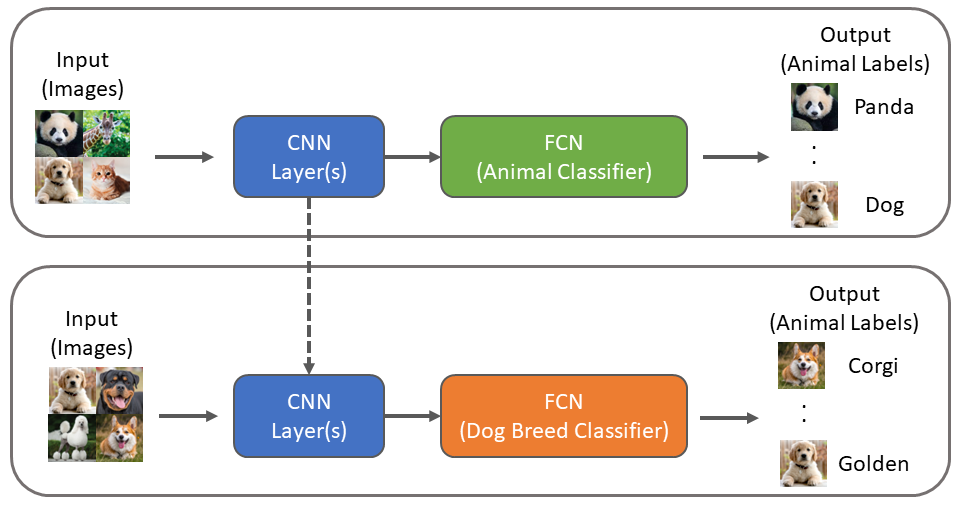

## Transfer Learning to identify Cats vs Dogs
In our example we'll use the Xception CNN model to train on a set of images of cats and dogs. Since we'll be importing pre-trained weights for the CNN, we'll only be training the "top" layer or the fully connected layers of our model.

### Loading/Pre-processing data
Before we can start training though, we'll need to format our data so that it can be used with the pre-existing Xception model

In [1]:
!pip install tensorflow_datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 1.9 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 2.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 3.8 MB/s eta 0:00:0000:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=4635fa99b2b44070bf406a57951e564f20e0923fbd970b7e95a5f1f09e841ef7
  Stored in directory: /Users/hannasong/Library/Caches/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [1]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.0 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 12.9 MB/s eta 0:00:01
  Using cached promise-2.3-py3-none-any.whl
     |████████████████████████████████| 78 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 168 kB 16.9 MB/s eta 0:00:01
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
     |████████████████████████████████| 162 kB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 228 kB 16.4 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
  Attempting uninstall: absl-py
    Found 

In [2]:
import tensorflow as tf
import keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

# Much like Sklearn, tensorflow provides prebuilt datasets
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # We'll splilt the data into train[40%], validation[10%], and test[10%]
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"""
Number of training samples: {tf.data.experimental.cardinality(train_ds)}\n\
Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}\n\
Number of test samples: {tf.data.experimental.cardinality(test_ds)}
"""
)


/Users/hannasong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [19]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

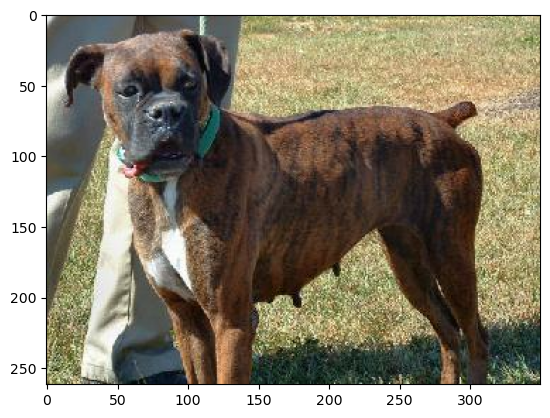

In [20]:
sample_img = next(iter(train_ds))

plt.imshow(sample_img[0])

In [21]:
# We'll need to reshape the images to a uniform size
size = (150, 150)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


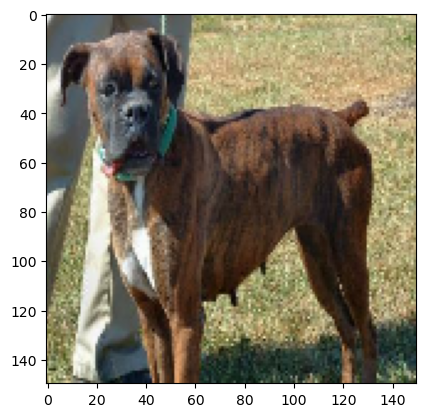

In [22]:
sample_img = next(iter(train_ds))

plt.imshow(np.round(sample_img[0]).astype(int))

In [23]:
# We'll also setup prefetching so that we can more easily load the data for training/testing
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


### Building the model
In the first line we'll load the Xception model trained on Imagenet data. However we'll explicity drop the fully connected layers so we can add our own (seen in the `include_top=False` line)

In [24]:
# From Keras we load the Xception model
base_model = keras.applications.Xception(
    weights="imagenet",  # Here we state we want to load the model with the imagenet weights
    input_shape=(150, 150, 3),
    include_top=False, # This states we won't include the "top" or the problem specific layers
)

# We can freeze the weights of any model/layer so they won't be updated when training the model
base_model.trainable = False
# We can also define our input layer based on the reshpaed images
inputs = keras.Input(shape=(150, 150, 3))

# With the base model defined we can construct our model
# 1. We add a rescaling layer for our inputs as the Xception model expects inputs to be scaled from (0, 255) to a range of (-1., +1.)
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# 2. We add the inputs to the scale_layer
x = scale_layer(inputs)
# 3. We pass the scaled inputs into the base_model (Xception) setting training=False
x = base_model(x, training=False)
# 4. We do some pooling to shrink number of features while keeping a representative representation of the image
x = keras.layers.GlobalAveragePooling2D()(x)
# 5. We add a dropout layer for better generalization
x = keras.layers.Dropout(0.2)(x)
# 6. We add a dense layers to learn from the image features
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
# 6. We add a final dense layer of 1 so we are predicting 
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                           

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, epochs=2, batch_size=75, validation_data=validation_ds)


Epoch 1/2
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f918bc5d790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f918bc5d790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f918bc5d790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
145/291 [=============>................] - ETA: 2:18 - loss: 0.1174 - accuracy: 0.9563

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


261/291 [=========================>....] - ETA: 27s - loss: 0.1081 - accuracy: 0.9598

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


275/291 [===========================>..] - ETA: 14s - loss: 0.1054 - accuracy: 0.9605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


278/291 [===========================>..] - ETA: 12s - loss: 0.1047 - accuracy: 0.9607

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


291/291 [==============================] - ETA: 0s - loss: 0.1043 - accuracy: 0.9607WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f918cd5f160> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f918cd5f160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f918cd5f160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f918cd5f160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 342s 1s/step - loss: 0.1043 - accuracy: 0.9607 - val_loss: 0.0797 - val_accuracy: 0.9686
Epoch 2/2
291/291 [==============================] - 347s 1s/step - loss: 0.0654 - accuracy: 0.9745 - val_loss: 0.0837 - val_accuracy: 0.9652


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f918cd8ad30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f918cd8ad30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f918cd8ad30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step


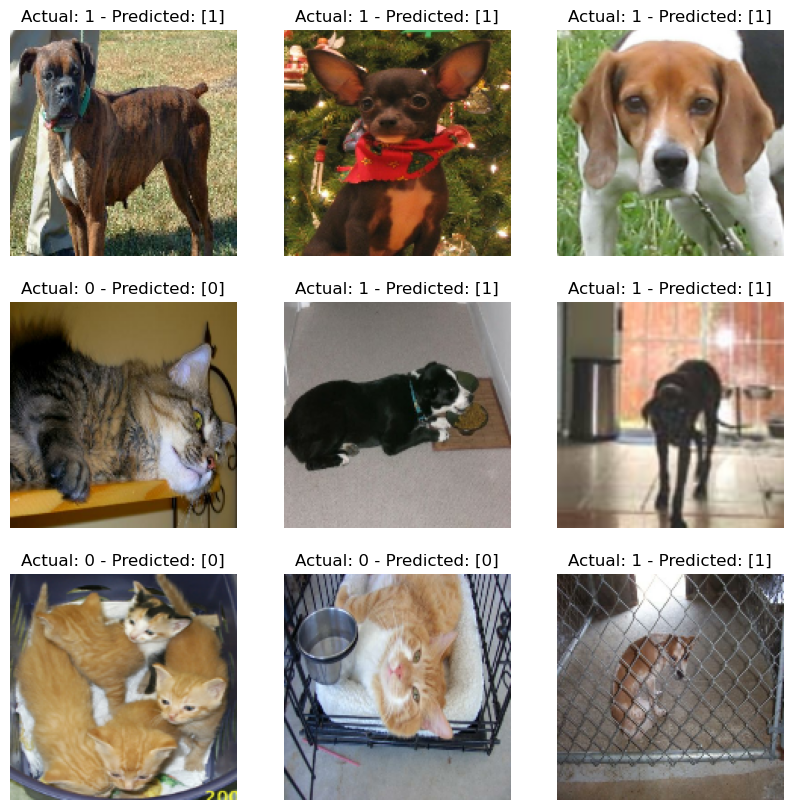

In [26]:
import matplotlib.pyplot as plt
import numpy as np

print(type(test_ds))
print(type(test_ds.take(1)))
print(test_ds)

plt.figure(figsize=(10, 10))
for ix, (images, labels) in enumerate(train_ds.take(1)):
    model_preds = model.predict(images)
    model_labels = np.where(model_preds>0.5, 1, 0)
    for iy in range(9):
        ax = plt.subplot(3, 3, iy + 1)
        plt.imshow(np.array(images[iy]).astype(int))
        plt.title(f"Actual: {int(labels[iy])} - Predicted: {model_labels[iy]}")
        plt.axis("off")

----
# Exploring Frozen Layers in Tensorflow

### Fashion MNIST Database
Typically everyone always uses the MNIST database for their first CNN. It stems from a challenge to identify what number has been written (0-9). Instead we will be using the fashion-MNIST database, which represents 10 different clothing options:
 - T-shirt/top
 - Trouser
 - Pullover
 - Dress
 - Coat
 - Sandal
 - Shirt
 - Sneaker
 - Bag
 - Ankle boot

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# This is our label to real world term dictionary
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}


In [ ]:
ix1 = (y_train == 0) | (y_train == 1)
iy1 = (y_test == 0) | (y_test == 1)

ix2 = (y_train == 3) | (y_train == 4)
iy2 = (y_test == 3) | (y_test == 4)


x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

init_x_train = x_train[ix1]
init_y_train = utils.to_categorical(y_train[ix1])

init_x_test = x_test[iy1]
init_y_test = utils.to_categorical(y_test[iy1])

next_x_train = x_train[ix2]
next_y_train = utils.to_categorical(y_train[ix2] - 3)

next_x_test = x_test[iy2]
next_y_test = utils.to_categorical(y_test[iy2] - 3)

## Our Model
We'll use the same CNN we developed earlier in the class

In [ ]:

def build_model(input_shape, num_classes):
    model = Sequential()
    # We defined the size of the images earlier, and will use that to define the input_shape
    # We will also define our kernel/filter to be 5x5, or process 25 pixels at a time
    # The strides parameter dictates how the filter passes over our images, in this case 1x and 1y at a time
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    # Next we add a Pooling layer, it's 2D because we are working a static image
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # After our set of convolutions, we flatten the image to create a ANN
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    
    # The softmax function will need to know how many classes we've defined
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return(model)
    
    

In [ ]:
input_shape = init_x_train[0].shape
num_classes = init_y_train.shape[1]

model = build_model(input_shape=input_shape, num_classes=num_classes)

model.fit(init_x_train, init_y_train, epochs=1, batch_size=50)

## Get Weights
To demonstrate this concept, we'll be freezing some of our layers (the dense layers) and copying the current weights, prior to the second training run.

This will let us see how we can manipulate how and when layers are trained vs used for inferencing.

In [ ]:
from copy import deepcopy

def get_weights(model, frozen_index):
    
    frozen_weights = []
    mod_weights = []
    
    for ix, layer in enumerate(model.layers):
        if ix < frozen_index:
            layer.trainable = False
            if 'max_pooling' not in layer.name:
                frozen_weights.append(deepcopy(layer.get_weights()[0]))
        else:
            layer.trainable = True
            if 'dense' in layer.name:
                mod_weights.append(deepcopy(layer.get_weights()[0]))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model, frozen_weights, mod_weights

In [ ]:
frozen_model, frozen_weights_init, mod_weights_init = get_weights(model, 4)

## Frozen Layers
We can view whether a layer is frozen by checking the trainable parameter of the given layer

In [ ]:
for ix, layer in enumerate(frozen_model.layers):
    print(f"Layer {ix} is trainable - {layer.trainable}")

In [ ]:
input_shape = init_x_train[0].shape
num_classes = next_y_test.shape[1]

frozen_model.fit(next_x_train, next_y_train, epochs=5, batch_size=25)

In [ ]:
_, frozen_weights_new, mod_weights_new = get_weights(frozen_model, 4)

## Checking the Progress
Through the two training processes we can see the difference in the weights between the frozen and unfrozen layers.

 - frozen_weights_new => frozen layer - second round of training
 - frozen_weights_init => frozen layer - first round of training
 
 - mod_weights_new => unfrozen layer - second round of training
 - mod_weights_init => unfrozen layer - first round of training

In [ ]:
mod_weights_init[0][0][:5]

In [ ]:
print(type(frozen_weights_init))

print(f"""Frozen weights - 
      Init: {frozen_weights_init[0][1][0][0][:5]}
      New: {frozen_weights_new[0][1][0][0][:5]}""")

print(f"""UnFrozen weights - 
      Init: {mod_weights_init[0][0][:5]}
      New: {mod_weights_new[0][0][:5]}""")

---

# Newer methods of "Transfer Learning" - LoRA
While not exactly the same concept or approach as transfer learning, LoRA or Low-Rank Adapation of Large Language Models (and diffusion models) is a newer methodology of taking pre-trained LLM's (and difussion models) and adapting them to specific sub problems. So while it doesn't follow the same technique as we just discussed it has the same goals.

## What is a LoRA
At the end of the day, all weights (the brains) behind every neural network are simply multi-dimensional matrices. Given the sheer size of these matrices (specifically when working with things like LLMs and Diffusion models) updating them is a very time intensive task. Rather than trying to update all of the weights at once, LoRA looks to identify/create a decomposed representation of our upates.

![lora](https://miro.medium.com/v2/resize:fit:720/format:webp/1*GmRC9gHJy1maqcFP7IRDcg.png)

Source: https://arxiv.org/pdf/2106.09685.pdf and https://betterprogramming.pub/unleash-your-digital-twin-how-fine-tuning-llm-can-create-your-perfect-doppelganger-b5913e7dda2e

## Breaking this down

Terms:
 - $WO$ = Weight matrix
 - $x$ = inputs
 - $h$ = hidden or intermediate layer
 - $WO_{updated}$ = Weight matrix after gradient descent
 - $WO\Delta$ = Updates for the weight matrix

Usually:\
$h = WO•x$\
$WO_{updated} = WO + WO\Delta$

LoRa defines:\
$WO\Delta = A*B$ **or** $WO_{updated} = WO + A*B$\
so\
$h = WO•x + AB•x$



In the LoRA we decompose the weight update matrix to simplify the math/processing required to calculate the updates

_Original Paper - https://arxiv.org/abs/2106.09685_

## Examples
https://softwarekeep.com/help-center/how-to-use-stable-diffusion-lora-models

## LoRA Pros
LoRA provides the following benefits:
 - Requires less memory to train
   - The decomposed representations are much smaller than the original weight matrice
 - Requires less processing to train
   - There are fewer calcualtions required to train a decomposed representation
 - Easily swappable
    - We can swap out different LoRA's for different purpsoes
 - Easily storable
    - Loras take up less space than an entirely new LLM/Diffusion model

## LoRA Cons
LoRA provides the following disadvantages:
 - Original model is a dependency
   - Improvements to base models most likely won't be compatible with LoRAs
 - Capped by original model
   - LoRA's may be able to improve specific functions for the original model, but like Transfer Learning are limited to it's capabiliites
 - May be undertrained/underperfom
   - A model trained from scratch may be able to perform better as LoRAs is ultiamtely an approximation technique

----
## Backup: Example Using Standard Keras
Within many deep learning libraries there are pre-trained models pre-configured for transfer learning. 

Xception is an example model that is a pre-trained CNN model. By not including the top, we can reuse this model, with it's weights, for different kinds of problems

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    base_model = ResNet50V2(weights='imagenet', pooling='avg', include_top=False)
    base_model.trainable = False
    base = base_model(inputs, training=False)
    # A Dense classifier with a single unit (binary classification)
    h_1 = Dense(2048, activation='relu')(base)
    h_2 = Dense(512, activation='relu')(h_1)
    outputs = Dense(num_classes, activation='softmax')(h_2)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
y_train_cat[0]

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)

model = build_model(x_train[0].shape, len(y_train_cat[0]))
model.fit(x_train, y_train_cat, batch_size=250, epochs=5)

## Exercise
Using pretrained model see if you can improve the performance of our George identifier model.

In [ ]:
# space for work